In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import hdbscan
import nltk
import spacy

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

spaci = spacy.load("en_core_web_sm")

In [2]:
df = pd.read_csv('octopus_energy_fb_comments.csv')
df.head()

,Unnamed: 0,fb_comment
0,0,Congratulations Laura
1,1,Rang u as my smart meter ain't working on scre...
2,2,"I just applied switched to Octopus , but can I..."
3,3,What do I need to do to get smart metres...
4,4,Could of phoned me


In [3]:
df.fb_comment.replace("_" , " ", regex=True, inplace = True)
df.fb_comment.replace("^" , " ", regex=True, inplace = True)

In [4]:
df.fb_comment.head()

0                                Congratulations Laura
1     Rang u as my smart meter ain't working on scr...
2     I just applied switched to Octopus , but can ...
3          What do I need to do to get smart metres...
4                                  Could of phoned me 
Name: fb_comment, dtype: object

In [5]:
import string
for punc in string.punctuation:
    try:
        df.fb_comment.replace(f"\{punc}", "", regex=True, inplace = True)
    except:
        pass

In [6]:
df.fb_comment[0]

' Congratulations Laura'

In [7]:
junk_words = "tqvm yessssssssssit youuuuuu nan nt citi kashif a very were yet than through via here rishisunak more much getting go going ive dont able when which who year barclays hsbcin amp like an no any since after banking im there out how starlingbank starling one only again over other then am may some do cant about banks would could its even their after has them get got within now all just if what or at had hsbcukbusiness up by into will an was our us so been hsbcuk co om ke ha gone your we can from as but to the hsbc and of you for are have they is my hsbc_uk with it in on this ðÿ be not bank me that"
junk_words_list = junk_words.split(" ")

In [8]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)

    text = re.sub(emoji_pattern, '', str(text))
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [9]:
def clean_data(text, small_word_lmt=2, extra_words=junk_words_list):
    list_data2=[]
    text = remove_unicode(text)
    sentence=text.lower().split(' ')
    for word in sentence:
        if word == "hi":
            word = word.replace("hi", "hello")
        if not word.startswith('http') \
           and word.isalpha() \
           and len(word)>small_word_lmt \
           and word not in extra_words:
            list_data2.append(word)
    return " ".join(list_data2)
df.fb_comment = df.fb_comment.apply(lambda x: clean_data(x))

In [10]:
df.fb_comment[0]

'congratulations laura'

In [11]:
def word_root(text):
    list_data3=[]
    
    doc = spaci(text)
    for token in doc:
        lemma = token.lemma_
        if lemma != "do":
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)
df.fb_comment = df.fb_comment.apply(lambda x: word_root(x))  

In [12]:
df.fb_comment[0]

'congratulation laura'

In [13]:
# adjustment for non-english words

# nltk.download('words')
# eng_words = set(nltk.corpus.words.words())
# df["eng"] = df.fb_comment.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i in eng_words]))
# df["noneng"] = df.fb_comment.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i not in eng_words]))
# df.noneng.tolist()

In [14]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([fb_comment.split() for fb_comment in df.fb_comment])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(20)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [15]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([fb_comment.split() for fb_comment in df.fb_comment])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(10)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [16]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [17]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [18]:
bigrams = [' '.join(x) for x in bigram_pmi.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in trigram_pmi.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [19]:
bigrams

['customer service', 'smart meter', 'still wait', 'octopus energy']

In [20]:
trigrams

['wait smart meter']

In [21]:
replace_ngrams = {"thank you for":"thank_you_for", "happy birthday":"happy_birthday",
                  "still wait smart meter":"still_wait_smart_meter",'octopus energy':"octopus_energy",
                  "wait smart meter":"wait_smart_meter",'customer service':'customer_service',
                  'smart meter':'smart_meter', 'still wait':'still_wait' }
for key, value in replace_ngrams.items():
    df.fb_comment.replace(f"\S*{key}\S*" , f"{value} "*3, regex=True, inplace = True)
    

In [22]:
# replace_key_words = ['delay', 'wait', 'on_hold', 'any_news', 'awful', 'disappointed', 'give_up', 'regret', 'worse', 'worst', 'unhappy', 'sucksunbelievable', 'frustrated', 'disgusted', 'happy', 'disgrace', 'awesome', 'fantastic', 'well_done', 'great', 'leave', 'bye', 'switch', 'covidenvironment', 'fossil', 'coal', 'fuel', 'climate', 'carbon', 'best', 'wonderfull']
# for key_word in replace_key_words:
#     df.fb_comment.replace(f"\S*{key_word}\S*" , f"{key_word} "*2, regex=True, inplace = True)


In [23]:
# df.drop(df[df.fb_comment.str.contains("tatacrucible")].index, axis=0,inplace=True)

In [24]:
df_clean = df.fb_comment
df_clean.shape

(768,)

In [25]:
df_clean = df_clean.dropna()
df_clean.shape

(768,)

In [26]:
list_data = df_clean.to_list()
list_data = [str(sent) for sent in list_data]

In [27]:
from sentence_transformers import SentenceTransformer

In [28]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1

In [29]:
model=SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings1 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

In [30]:
# embeddings1[embeddings1.argmax()]

In [31]:
model=SentenceTransformer('paraphrase-distilroberta-base-v1')
embeddings2 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

In [32]:
embeddings1_norm = embeddings1 /  np.linalg.norm(embeddings1, axis=1, keepdims=True)
embeddings2_norm = embeddings2 /  np.linalg.norm(embeddings2, axis=1, keepdims=True)

In [33]:
import umap

In [34]:
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

In [35]:
UMAP_bert1 = umap.UMAP(n_components=2).fit_transform(embeddings1)
UMAP_bert1_norm = umap.UMAP(n_components=2).fit_transform(embeddings1_norm)

UMAP_bert2 = umap.UMAP(n_components=2).fit_transform(embeddings2)
UMAP_bert2_norm = umap.UMAP(n_components=2).fit_transform(embeddings2_norm)

#n_neighbors=10, min_dist=0.0, 

In [36]:
PCA_bert1 = PCA(n_components=2).fit_transform(embeddings1)
PCA_bert1_norm = PCA(n_components=2).fit_transform(embeddings1_norm)

PCA_bert2 = PCA(n_components=2).fit_transform(embeddings2)
PCA_bert2_norm = PCA(n_components=2).fit_transform(embeddings2_norm)

In [37]:
tSNE_bert1 = TSNE(n_components=2).fit_transform(embeddings1)
tSNE_bert1_norm = TSNE(n_components=2).fit_transform(embeddings1_norm)

tSNE_bert2 = TSNE(n_components=2).fit_transform(embeddings2)
tSNE_bert2_norm = TSNE(n_components=2).fit_transform(embeddings2_norm)

In [38]:
from pyclustertend import hopkins
hopkins(UMAP_bert2,UMAP_bert2.shape[0])

0.017154740389843326

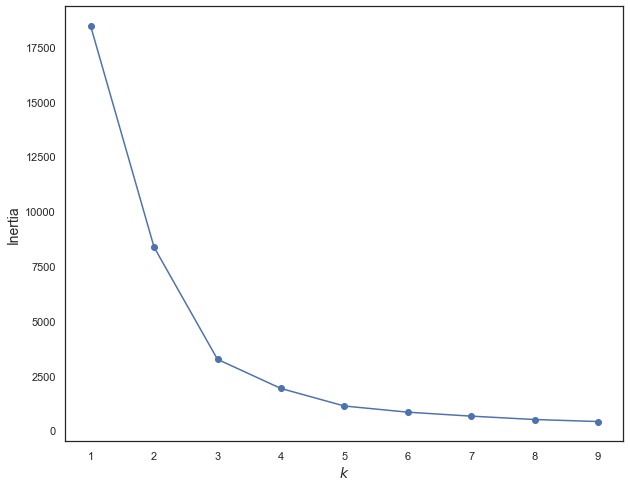

In [39]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(UMAP_bert2)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [54]:
def cluster_results(Kmeans_clusters=4):
    
    ClusterDict = {}
    dim_embeddings = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                      "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                      "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                      "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                      "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                      "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm}
    
    for key, val in dim_embeddings.items():
        ClusterDict[key] = KMeans(n_clusters=Kmeans_clusters).fit_predict(val)
        ClusterDict[key+"_hdbscan"] = hdbscan.HDBSCAN(min_samples = 30,
                           min_cluster_size=15,
                           metric = 'euclidean',
                           cluster_selection_epsilon = 0.25,
                           cluster_selection_method = "eom").fit_predict(val)
    return ClusterDict

In [55]:
clustering_result = cluster_results()

In [56]:
def plot(cluster = clustering_result):    
    reduced_dims = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                    "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                    "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                    "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                    "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                    "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm,
                    "UMAP_bert1_hdbscan" : UMAP_bert1, "UMAP_bert1_norm_hdbscan" : UMAP_bert1_norm, 
                    "UMAP_bert2_hdbscan" : UMAP_bert2, "UMAP_bert2_norm_hdbscan" : UMAP_bert2_norm,
                    "PCA_bert1_hdbscan" : PCA_bert1, "PCA_bert1_norm_hdbscan" : PCA_bert1_norm, 
                    "PCA_bert2_hdbscan" : PCA_bert2, "PCA_bert2_norm_hdbscan" : PCA_bert2_norm,
                    "tSNE_bert1_hdbscan" : tSNE_bert1, "tSNE_bert1_norm_hdbscan" :  tSNE_bert1_norm, 
                    "tSNE_bert2_hdbscan" : tSNE_bert2, "tSNE_bert2_norm_hdbscan" : tSNE_bert2_norm}

    for clustee_name, clustee in cluster.items():
        clustered = (clustee >= 0)
        reduced_dim = reduced_dims[clustee_name]
            
        print(f"----------{clustee_name}--------------------")

        unique, counts = np.unique(clustee, return_counts=True)
        print(dict(zip(unique, counts)))

        plt.scatter(reduced_dim[~clustered, 0],
                    reduced_dim[~clustered, 1],
                    c=(0.5,0.5,0.5),
                    # s=1,
                    alpha=0.5
                    )
        plt.scatter(reduced_dim[clustered, 0],
                    reduced_dim[clustered, 1],
                    c=clustee[clustered],
                    # s=1,
                    cmap='Spectral')
        plt.show()

----------UMAP_bert1--------------------
{0: 217, 1: 228, 2: 157, 3: 166}


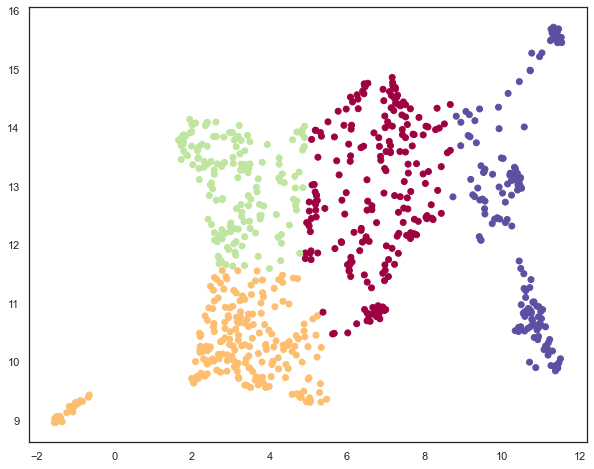

----------UMAP_bert1_hdbscan--------------------
{-1: 246, 0: 32, 1: 61, 2: 44, 3: 88, 4: 20, 5: 277}


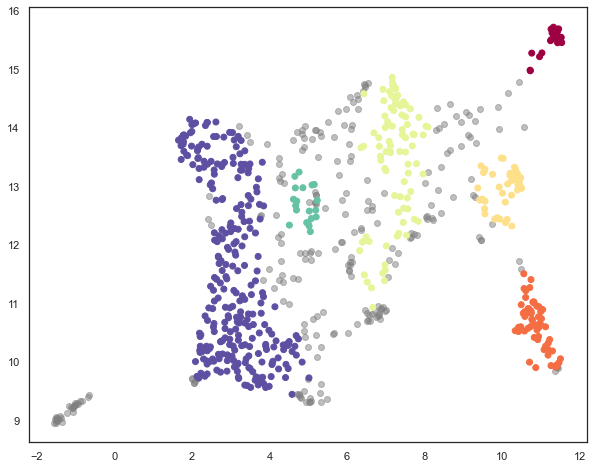

----------UMAP_bert1_norm--------------------
{0: 165, 1: 211, 2: 157, 3: 235}


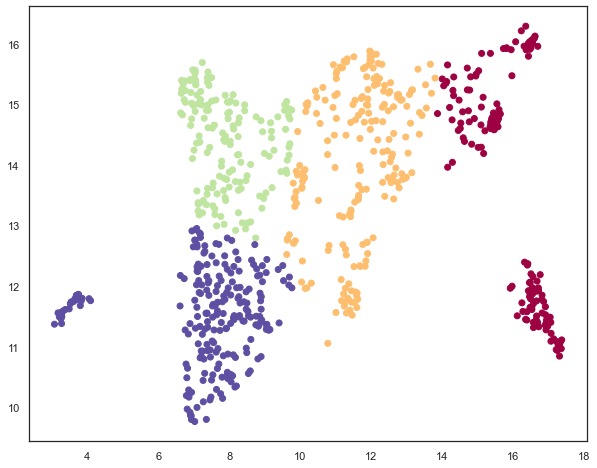

----------UMAP_bert1_norm_hdbscan--------------------
{-1: 30, 0: 69, 1: 669}


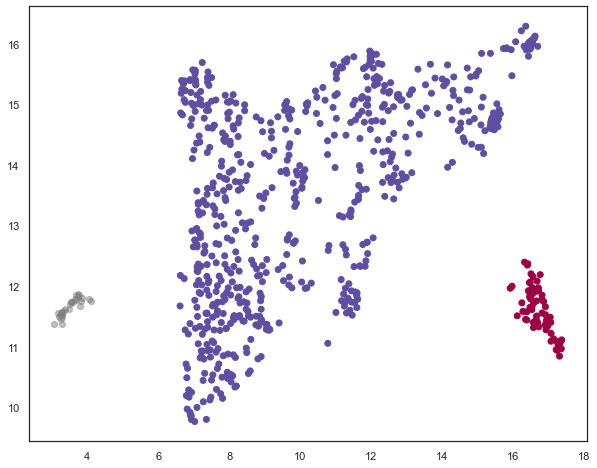

----------UMAP_bert2--------------------
{0: 355, 1: 23, 2: 83, 3: 307}


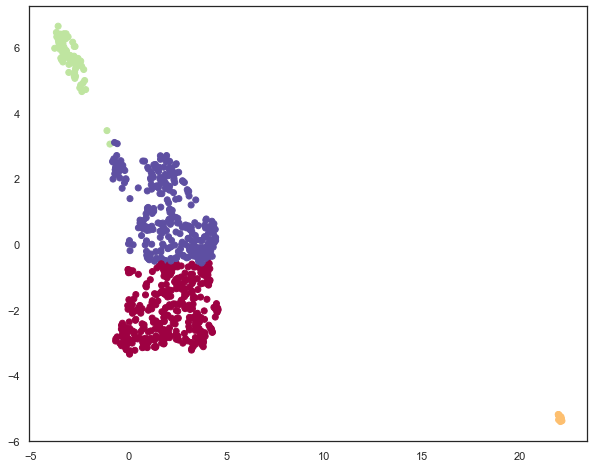

----------UMAP_bert2_hdbscan--------------------
{-1: 48, 0: 81, 1: 36, 2: 603}


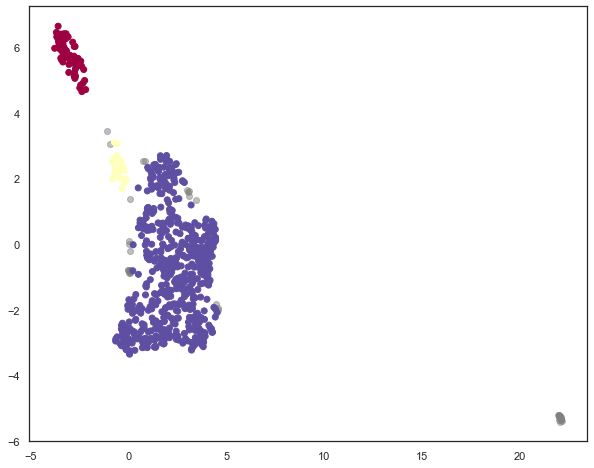

----------UMAP_bert2_norm--------------------
{0: 228, 1: 163, 2: 227, 3: 150}


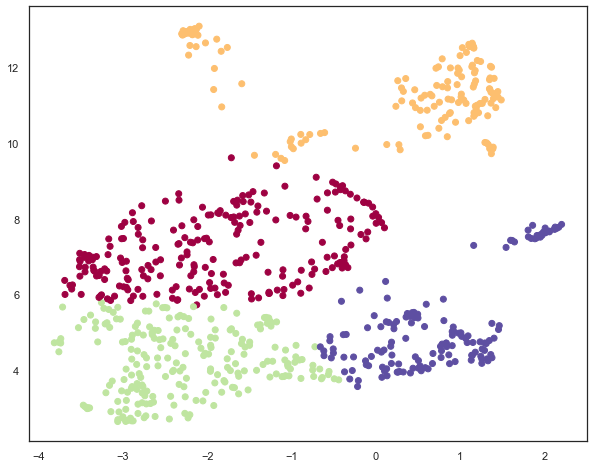

----------UMAP_bert2_norm_hdbscan--------------------
{-1: 19, 0: 34, 1: 110, 2: 576, 3: 29}


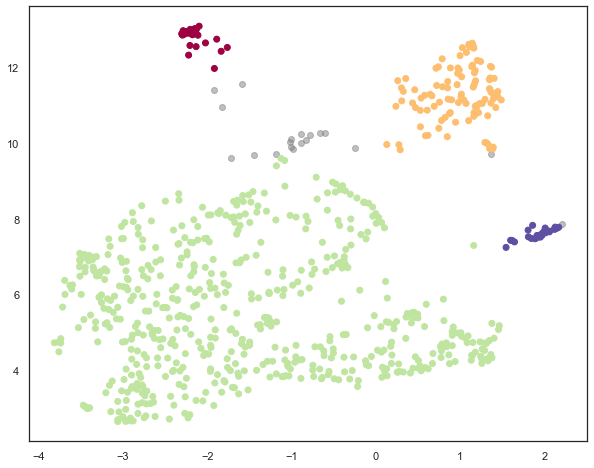

----------PCA_bert1--------------------
{0: 134, 1: 215, 2: 242, 3: 177}


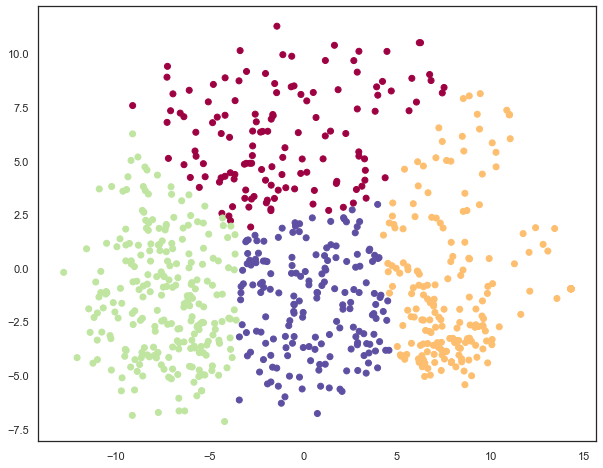

----------PCA_bert1_hdbscan--------------------
{-1: 446, 0: 196, 1: 126}


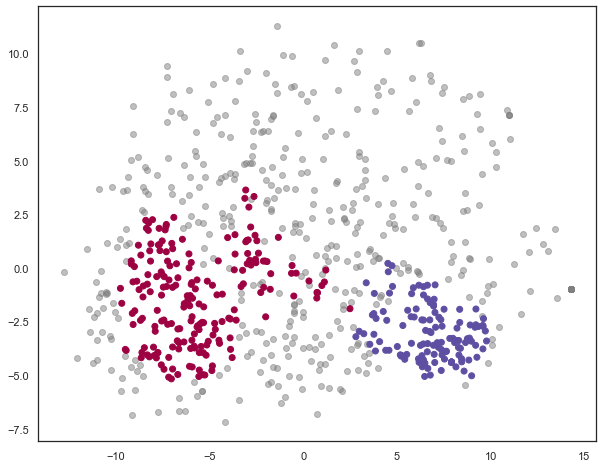

----------PCA_bert1_norm--------------------
{0: 154, 1: 219, 2: 159, 3: 236}


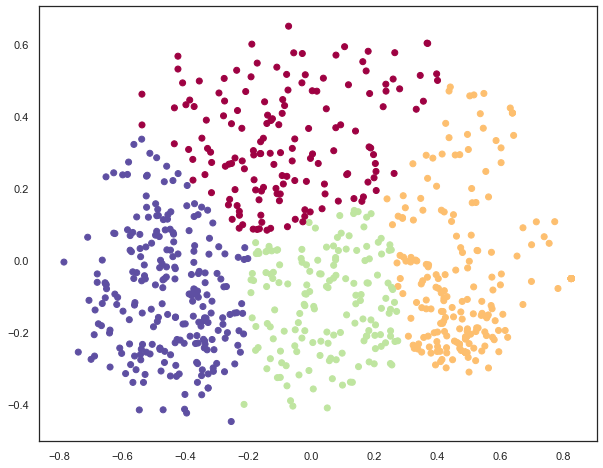

----------PCA_bert1_norm_hdbscan--------------------
{-1: 89, 0: 20, 1: 659}


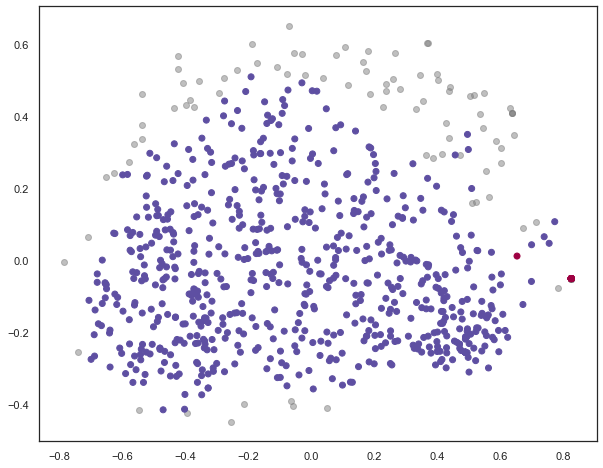

----------PCA_bert2--------------------
{0: 159, 1: 242, 2: 23, 3: 344}


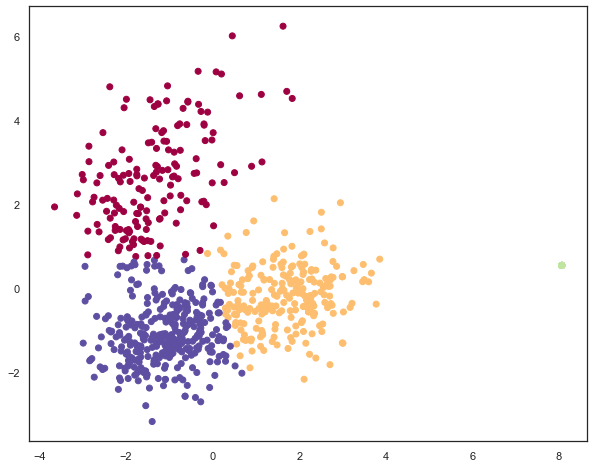

----------PCA_bert2_hdbscan--------------------
{-1: 255, 0: 36, 1: 477}


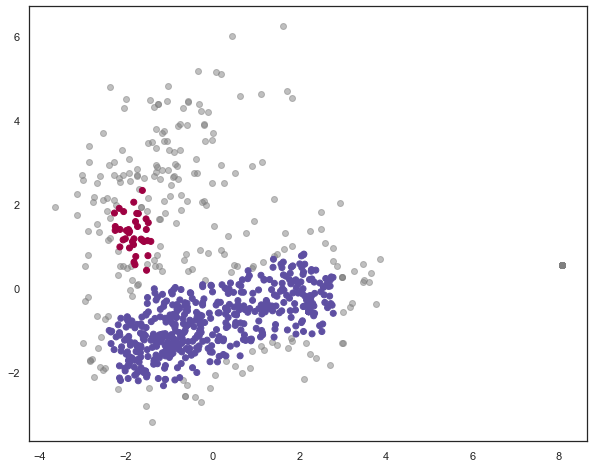

----------PCA_bert2_norm--------------------
{0: 205, 1: 160, 2: 174, 3: 229}


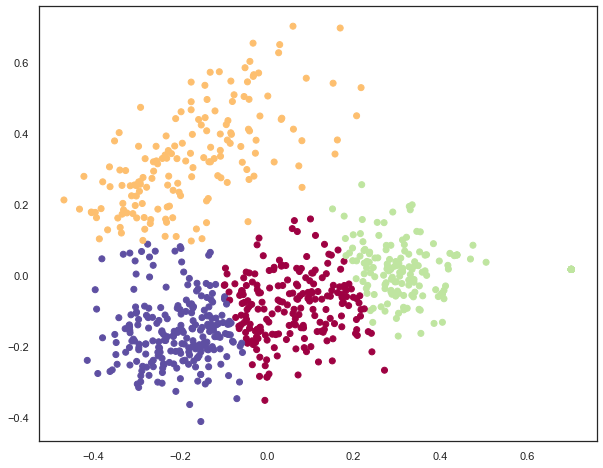

----------PCA_bert2_norm_hdbscan--------------------
{-1: 174, 0: 76, 1: 518}


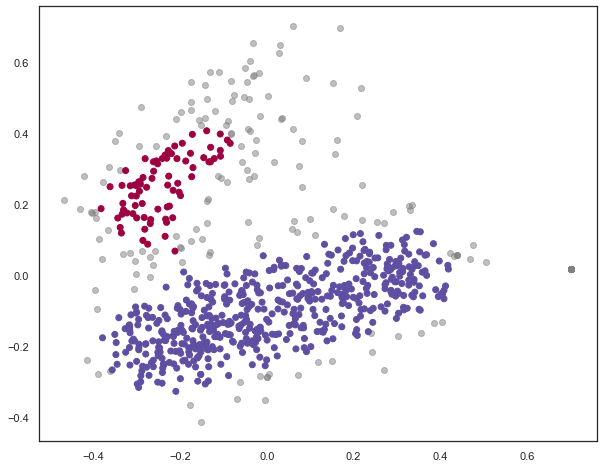

----------tSNE_bert1--------------------
{0: 187, 1: 209, 2: 205, 3: 167}


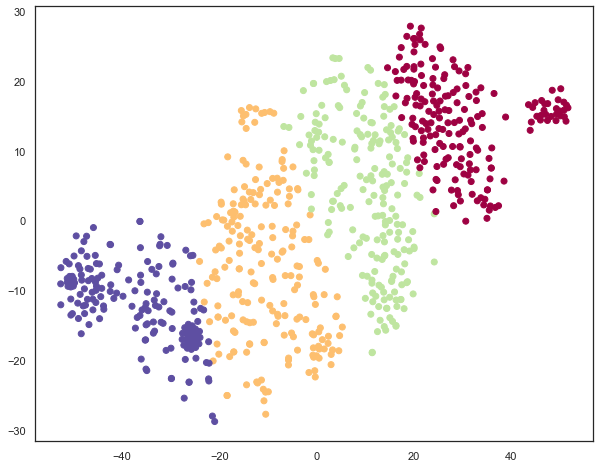

----------tSNE_bert1_hdbscan--------------------
{-1: 384, 0: 230, 1: 46, 2: 52, 3: 56}


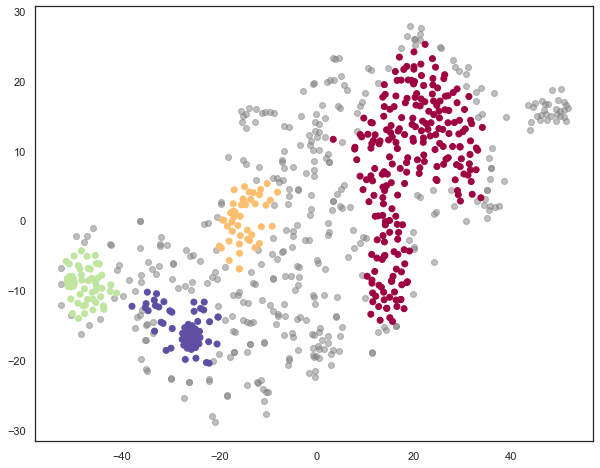

----------tSNE_bert1_norm--------------------
{0: 169, 1: 161, 2: 226, 3: 212}


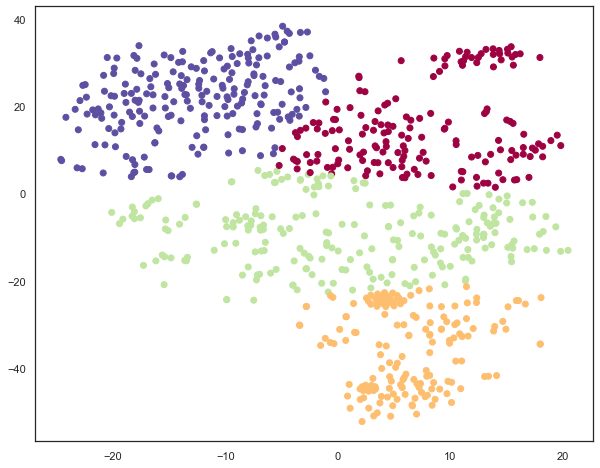

----------tSNE_bert1_norm_hdbscan--------------------
{-1: 91, 0: 22, 1: 655}


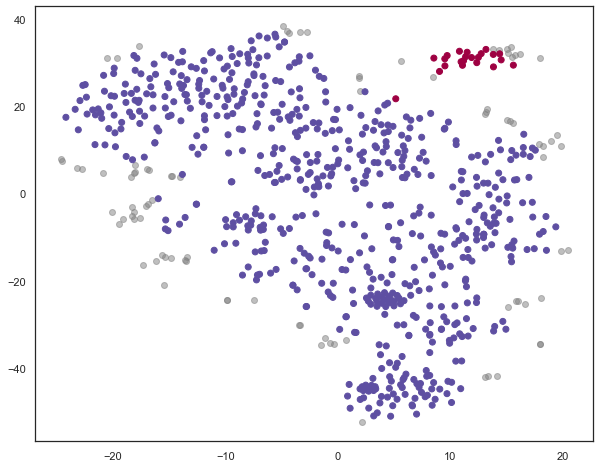

----------tSNE_bert2--------------------
{0: 205, 1: 217, 2: 110, 3: 236}


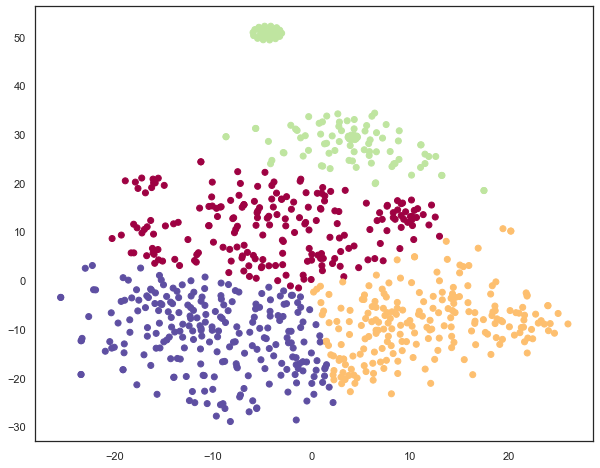

----------tSNE_bert2_hdbscan--------------------
{-1: 333, 0: 51, 1: 29, 2: 323, 3: 32}


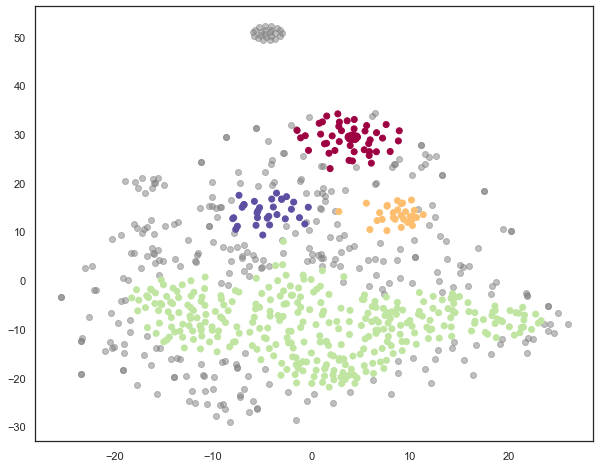

----------tSNE_bert2_norm--------------------
{0: 210, 1: 187, 2: 176, 3: 195}


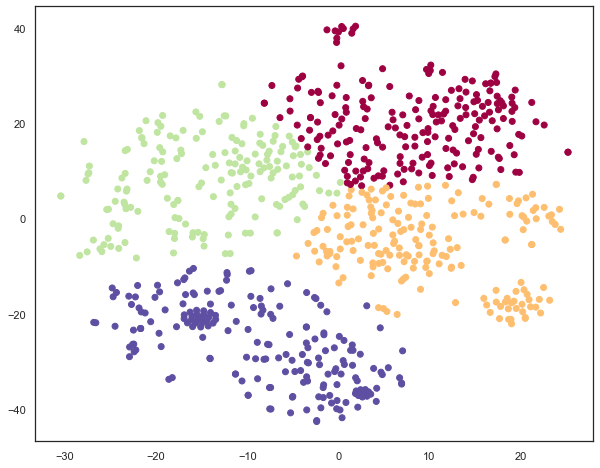

----------tSNE_bert2_norm_hdbscan--------------------
{-1: 218, 0: 149, 1: 19, 2: 382}


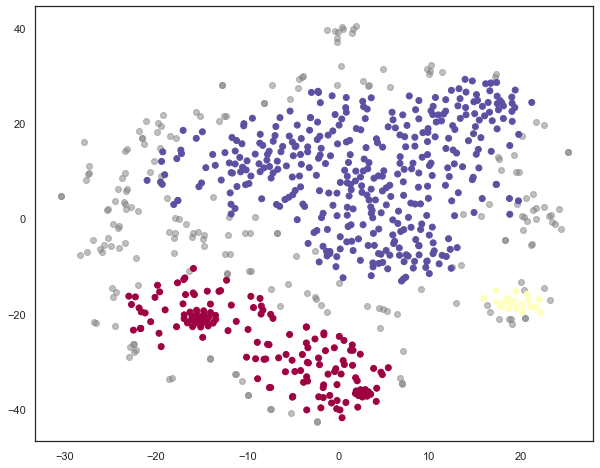

In [57]:
plot()

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfmatrix(data, vectorizer):
    terms = vectorizer.fit_transform(data)
    return pd.DataFrame(terms.toarray(), columns = vectorizer.get_feature_names())

In [67]:
def cluster_words(clustering_result=clustering_result, top_n = 20):
    for name, value in clustering_result.items():
        print(f"===================================={name}=============================================")
    
        #creatin new df in order to groupby same clusters
        cluster = value
        docs = pd.DataFrame(df_clean)
        docs["cluster"] = cluster

        labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"fb_comment": " ".join})
                
        tfidf_vec = TfidfVectorizer(max_df=0.9)
        try:
            tfidf_mat = tfidfmatrix(labeled_docs.fb_comment, tfidf_vec)
        except: pass
        
        global most_common
        most_common = pd.DataFrame({n: tfidf_mat.T[col].nlargest(top_n).index.tolist() 
                                for n, col in enumerate(tfidf_mat.T)}).T
#         most_common.index = np.unique(cluster)
        display(most_common)

In [68]:
cluster_words()

====================================UMAP_bert1=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,smart_meter,email,still_wait,good,know,still_wait_smart_meter,reply,send,use,thank,company,customer,great,link,win,customer_service,nt,someone,work,amazing
1,smart_meter,month,email,customer_service,octopus_energy,octopus,still_wait,week,apple,meter,company,send,still,take,back,reply,time,call,gas,bill
2,octopus_energy,smart_meter,octopus,good,great,company,electric,customer,customer_service,car,really,year,thank,new,make,octopusenergy,wait_smart_meter,happy,meter,time
3,lisa,middleton,wind,rebecca,robert,windy,gemma,jame,jamie,should,alan,amanda,andrew,barker,calvin,caroline,chloe,cooper,ireland,michelle


====================================UMAP_bert1_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,email,apple,customer_service,smart_meter,still_wait,great,company,use,octopus,reply,well,good,please,make,customer,know,think,nt,send,news
1,penyfan,neither,cancel,effort,next,charge,look,phone,wait,leave,abby,above,absolute,absolutely,accept,accidentally,accolade,account,acknowledge,acknowledgement
2,lisa,middleton,rebecca,gemma,louise,amanda,barker,calvin,caroline,chloe,cooper,michelle,santo,sophie,stevenson,claire,robert,should,alex,allen
3,wind,windy,alan,andrew,scott,jame,alun,anderson,ashton,austin,badger,beetlehow,ben,beneath,bianco,blofeld,blot,blow,blowmenthalorlando,calvado
4,win,know,good,love,say,thank,amazing,please,use,anything,great,hello,keep,nothing,someone,tell,think,well,anyone,code
5,smart_meter,still_wait_smart_meter,electric,power,tariff,instal,car,energy,green,please,service,take,work,problem,switch,boot,contribute,difficult,energythe,secure
6,smart_meter,octopus_energy,octopus,email,month,customer_service,week,meter,customer,send,company,be,still_wait,still,switch,say,back,bill,call,reply


====================================UMAP_bert1_norm=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,lisa,middleton,louise,wind,rebecca,robert,windy,gemma,jamie,should,alan,amanda,andrew,barker,calvin,caroline,chloe,cooper,ireland,michelle
1,smart_meter,email,still_wait,reply,still_wait_smart_meter,good,know,well,send,use,thank,customer,great,link,company,customer_service,someone,nt,amazing,account
2,octopus_energy,smart_meter,octopus,good,great,company,electric,customer,car,well,customer_service,thank,really,year,make,new,octopusenergy,wait_smart_meter,happy,time
3,smart_meter,month,email,octopus_energy,customer_service,octopus,still_wait,week,reply,apple,meter,send,company,still,call,take,time,back,gas,nt


====================================UMAP_bert1_norm_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,apple,cake,make,pie,pink,bake,ice,use,chocolate,vegan,time,caramel,cinnamon,loaf,vanilla,yoghurt,bit,come,crumble,electricity
1,lisa,middleton,louise,rebecca,gemma,amanda,barker,calvin,caroline,chloe,cooper,michelle,santo,sophie,stevenson,claire,robert,should,alex,allen
2,smart_meter,octopus_energy,email,octopus,customer_service,month,company,please,customer,meter,send,still_wait,reply,switch,back,nt,good,well,call,be


====================================UMAP_bert2=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,smart_meter,octopus_energy,octopus,month,meter,email,still_wait,switch,company,week,say,still,send,please,take,bill,good,be,hello,customer
1,abby,above,absolute,absolutely,accept,accidentally,accolade,account,acknowledge,acknowledgement,acknowledgementthank,acquaintance,action,active,actually,adam,add,address,adequacy,adjust
2,lisa,middleton,rebecca,robert,alan,amanda,andrew,barker,calvin,caroline,cooper,michelle,santo,scott,smith,sophie,stevenson,jame,claire,louise
3,customer_service,email,apple,company,great,please,good,reply,send,thank,well,time,answer,know,love,make,use,win,back,call


====================================UMAP_bert2_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,still_wait,please,quiz,windy,octopus_energy,wind,engine,mine,wait,alun,android,beneath,blow,blowmenthalorlando,boot,caerphilly,cheyney,dale,davy,dieselwindirection
1,lisa,middleton,rebecca,robert,jame,alan,amanda,andrew,barker,calvin,caroline,cooper,michelle,santo,scott,smith,sophie,stevenson,claire,louise
2,apple,cake,make,pie,pink,bake,ice,use,chocolate,crumble,vegan,come,good,time,caramel,cinnamon,loaf,vanilla,yoghurt,bit
3,smart_meter,octopus_energy,customer_service,email,octopus,month,company,switch,meter,send,reply,customer,please,nt,good,well,call,be,still_wait,try


====================================UMAP_bert2_norm=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,customer_service,email,please,reply,great,send,company,switch,thank,win,answer,good,back,customer,know,time,code,use,make,someone
1,lisa,middleton,jame,wind,lee,rebecca,robert,windy,alan,amanda,andrew,barker,calvin,caroline,cooper,forest,michelle,santo,scott,smith
2,smart_meter,octopus_energy,month,still_wait,email,meter,week,company,gas,still,instal,bill,switch,say,take,try,customer,nt,send,tariff
3,octopus_energy,apple,good,great,customer,customer_service,cake,company,make,please,switch,thank,account,happy,say,think,octopusenergy,be,come,reading


====================================UMAP_bert2_norm_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,love,forest,app,android,arsenal,beetlehow,bellerin,blofeld,blot,boot,cobbler,conversion,done,gateaux,landscape,offshore,onshore,programme,afford,always
1,tentacle,voltaire,actually,believe,display,house,next,order,phone,thursday,charge,congratulation,effort,join,leave,abby,above,absolute,absolutely,accept
2,lisa,middleton,jame,lee,rebecca,robert,windy,gemma,louise,quiz,wind,alan,amanda,andrew,barker,calvin,caroline,cooper,michelle,santo
3,smart_meter,octopus_energy,email,customer_service,octopus,month,company,switch,please,customer,meter,send,still_wait,reply,still,back,nt,good,be,think
4,apple,cake,make,bake,pie,pink,ice,use,chocolate,vegan,good,time,caramel,loaf,vanilla,yoghurt,come,crumble,electricity,great


====================================PCA_bert1=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,smart_meter,octopus_energy,great,customer_service,happy,news,year,awesome,really,ever,brilliant,hear,move,nice,time,amazing,anything,easy,far,gas
1,lisa,middleton,amazing,jame,windy,tell,alan,amanda,andrew,caroline,cooper,michelle,scott,smith,sophie,stevenson,yes,amount,claire,martin
2,smart_meter,email,octopus_energy,month,customer_service,week,call,still_wait,ago,time,take,try,reading,bill,apple,payment,last,debit,monthly,wait_smart_meter
3,email,still_wait,apple,customer_service,still_wait_smart_meter,account,comment,electric,call,month,change,smart_meter,take,answer,post,time,night,off,speak,lee


====================================PCA_bert1_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,smart_meter,octopus_energy,company,customer_service,great,month,customer,meter,time,back,bill,gas,love,thank,day,look,move,need,work,account
1,smart_meter,customer_service,octopus_energy,month,meter,hello,try,apple,time,ago,back,company,answer,tariff,thank,account,reading,customer,work,end
2,lisa,middleton,alan,amanda,andrew,caroline,chloe,cooper,michelle,scott,smith,sophie,stevenson,claire,jame,louise,martin,rebecca,referal,robert


====================================PCA_bert1_norm=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,smart_meter,octopus_energy,great,customer_service,happy,really,year,awesome,nice,ever,anything,brilliant,car,hear,still_wait_smart_meter,change,easy,far,move,time
1,lisa,middleton,amazing,jame,windy,tell,alan,amanda,andrew,caroline,cooper,michelle,scott,smith,sophie,stevenson,yes,amount,claire,congratulation
2,email,still_wait,apple,customer_service,account,comment,electric,still_wait_smart_meter,answer,change,post,take,time,month,night,off,speak,lee,pick,call
3,smart_meter,octopus_energy,email,month,customer_service,week,still_wait,ago,time,call,take,try,bill,payment,last,debit,wait_smart_meter,new,account,reading


====================================PCA_bert1_norm_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,smart_meter,good,octopus_energy,octopus,company,customer_service,great,well,make,month,still_wait,customer,email,news,really,keep,love,amazing,energy,ever
1,order,abby,above,absolute,absolutely,accept,accidentally,accolade,account,acknowledge,acknowledgement,acknowledgementthank,acquaintance,action,active,actually,adam,add,address,adequacy
2,smart_meter,octopus,octopus_energy,email,customer_service,month,switch,company,send,call,meter,try,customer,hello,week,still,still_wait,reply,use,account


====================================PCA_bert2=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,octopus_energy,octopus,smart_meter,month,email,customer_service,send,switch,good,still,be,meter,week,company,please,octopusenergy,customer,well,say,account
1,lisa,middleton,apple,well,win,amazing,good,love,great,news,code,bake,jame,louise,lee,rebecca,robert,windy,cake,comment
2,abby,above,absolute,absolutely,accept,accidentally,accolade,account,acknowledge,acknowledgement,acknowledgementthank,acquaintance,action,active,actually,adam,add,address,adequacy,adjust
3,smart_meter,customer_service,email,month,still_wait,switch,meter,company,send,back,week,use,customer,please,reply,still,take,try,time,nt


====================================PCA_bert2_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,octopus_energy,think,apple,have,need,link,nothing,contact,octopusenergy,people,cake,far,mine,promise,claim,post,see,way,myself,amount
1,octopus_energy,forward,monitor,sorted,advise,can,chance,clear,install,not,octopusenergy,respond,scottishpower,soon,staff,unless,acknowledgementthank,adjustment,advanced,afterwards
2,still_wait_smart_meter,think,apple,need,middleton,car,first,have,should,lisa,news,many,before,re,enter,every,idea,link,respond,see


====================================PCA_bert2_norm=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,use,customer_service,think,car,code,smart_meter,win,electric,bake,energy,link,time,want,wind,anyone,customer,still_wait,switch,work,bit
1,octopus_energy,octopus,smart_meter,month,email,customer_service,send,switch,octopusenergy,customer,still,be,meter,say,week,account,move,reading,energy,hello
2,lisa,middleton,amazing,robert,win,alan,amanda,andrew,barker,calvin,constantine,cooper,forest,michelle,santo,scott,smith,sophie,stevenson,jame
3,smart_meter,email,customer_service,month,still_wait,back,meter,send,switch,customer,reply,week,call,take,time,try,use,nt,say,still


====================================PCA_bert2_norm_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,octopus_energy,apple,use,nothing,cake,myself,monitor,old,agile,bake,octopusenergy,rate,website,profit,amazing,current,daughter,else,everyone,experience
1,octopus_energy,forward,octopusenergy,never,today,until,can,check,double,friend,not,regard,being,brother,cheque,invite,manage,report,sorted,app
2,use,still_wait_smart_meter,apple,first,win,payment,middleton,should,old,today,lisa,many,nothing,power,enter,every,idea,never,respond,door


====================================tSNE_bert1=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,smart_meter,month,email,customer_service,octopus_energy,octopus,week,apple,meter,company,send,still,time,take,back,call,customer,try,debit,gas
1,email,great,good,well,know,company,reply,use,customer_service,send,answer,back,need,someone,thank,link,sort,customer,nt,amazing
2,smart_meter,octopus_energy,octopus,still_wait,good,company,customer,electric,new,car,great,customer_service,thank,well,still_wait_smart_meter,wait_smart_meter,meter,month,make,fit
3,lisa,middleton,louise,wind,rebecca,robert,windy,gemma,jame,jamie,alan,amanda,andrew,barker,calvin,caroline,chloe,cooper,garnett,ireland


====================================tSNE_bert1_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,smart_meter,apple,email,still_wait,octopus,customer_service,please,use,reply,switch,company,know,back,send,want,customer,month,good,code,octopus_energy
1,smart_meter,octopus_energy,octopus,email,month,customer_service,meter,week,switch,send,company,say,ago,be,time,try,still,nt,customer,call
2,good,amazing,great,love,news,well,win,brilliant,company,customer_service,luck,awesome,congratulation,fantastic,idea,keep,make,service,arsenal,beautiful
3,middleton,lisa,amanda,caroline,cooper,santo,sophie,rebecca,gemma,louise,alex,allen,angela,anne,ban,bennett,betty,bonner,borkowska,carlina
4,please,order,yes,alun,austin,ben,bianco,blofeld,calvado,daniel,fyi,gustav,gusthav,gâteau,harmour,jones,jorge,maclean,mangnall,marcus


====================================tSNE_bert1_norm=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,smart_meter,octopus_energy,octopus,apple,good,great,company,customer,customer_service,make,really,wait_smart_meter,thank,year,fit,time,work,cake,new,happy
1,lisa,middleton,louise,wind,rebecca,robert,windy,jame,jamie,should,alan,amanda,andrew,barker,calvin,caroline,chloe,cooper,garnett,ireland
2,octopus,please,well,reply,good,know,send,great,someone,thank,use,company,customer,customer_service,message,link,nt,amazing,account,need
3,smart_meter,octopus_energy,still_wait,month,customer_service,octopus,week,reply,meter,send,company,still,call,back,take,time,nt,please,be,customer


====================================tSNE_bert1_norm_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,still_wait,smart_meter,customer_service,still_wait_smart_meter,car,electric,energy,why,know,nothing,switch,many,please,problem,seem,bad,change,customer,during,love
1,cake,pink,ice,chocolate,vegan,caramel,cinnamon,loaf,vanilla,yoghurt,crumble,miller,old,abby,archie,ava,banana,birthday,brighten,bun
2,smart_meter,octopus_energy,email,customer_service,month,company,nt,please,switch,meter,customer,send,be,reply,back,well,still_wait,thank,day,someone


====================================tSNE_bert2=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,apple,great,good,well,company,love,win,car,cake,make,energy,use,code,quiz,wind,amazing,bake,ever,news,thank
1,octopus_energy,smart_meter,octopus,month,email,switch,meter,still_wait_smart_meter,good,send,still_wait,still,week,company,please,customer_service,hello,last,say,take
2,lisa,middleton,rebecca,robert,gemma,alan,amanda,andrew,barker,calvin,caroline,cooper,michelle,santo,scott,smith,sophie,stevenson,jame,louise
3,email,smart_meter,customer_service,month,reply,switch,send,still_wait,meter,back,call,try,company,please,nt,use,gas,sort,bill,say


====================================tSNE_bert2_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,octopus,company,good,well,love,code,customer_service,want,please,great,think,use,month,quiz,car,switch,thank,know,octopus_energy,need
1,lisa,middleton,barker,calvin,caroline,michelle,santo,scott,sophie,stevenson,claire,rebecca,louise,alex,allen,angela,anne,ashton,austin,bennett
2,apple,cake,bake,make,pie,pink,chocolate,use,good,caramel,cinnamon,crumble,ice,vegan,come,time,old,alas,archie,ava
3,smart_meter,octopus_energy,email,octopus,customer_service,still_wait,month,send,customer,meter,switch,company,reply,still,call,nt,back,be,bill,please
4,amazing,wow,yes,look,please,sound,great,idea,beautiful,blimey,blofeld,enjoyable,equal,excited,grease,hawkward,interesting,lightning,motor,ohmy


====================================tSNE_bert2_norm=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,smart_meter,month,octopus_energy,still_wait,meter,email,company,bill,customer_service,week,customer,still,say,take,switch,still_wait_smart_meter,wait_smart_meter,gas,pay,work
1,octopus_energy,apple,good,company,smart_meter,customer,make,year,customer_service,switch,cake,energy,email,month,ice,move,say,account,be,happy
2,email,customer_service,reply,send,code,switch,answer,know,use,back,anyone,win,message,try,still_wait,customer,someone,car,referral,week
3,lisa,middleton,amazing,jame,hawk,rebecca,robert,alan,amanda,andrew,barker,bird,calvin,caroline,cooper,forest,michelle,santo,scott,smith


====================================tSNE_bert2_norm_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,great,company,still_wait,good,know,win,apple,quiz,use,news,referral,answer,link,octopus,well,car,electric,month,wind,love
1,lisa,middleton,love,jame,rebecca,robert,amazing,alan,amanda,andrew,barker,calvin,forest,michelle,santo,scott,smith,sophie,stevenson,well
2,apple,cake,pink,make,chocolate,vanilla,ice,use,crumble,pie,vegan,come,idea,old,time,archie,ava,banana,birthday,butter
3,smart_meter,octopus_energy,email,octopus,customer_service,meter,send,month,reply,switch,customer,company,say,back,please,nt,someone,be,still_wait,reading
